In [ ]:
# STEP 1: Install required libraries
!pip uninstall -y diffusers -q
!pip install diffusers==0.29.0 -q
!pip install transformers accelerate torch torchvision matplotlib scikit-image xformers -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 14.2 MB/s eta 0:00:00


In [ ]:
# STEP 2: Upload and Extract ZIP File
from google.colab import files
import zipfile, os

uploaded = files.upload()  # Upload bacterial.zip here
zip_filename = next(iter(uploaded))
output_dir = "./bacterial_dataset"
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"✅ Extracted {zip_filename} to {output_dir}")

Saving bacterial.zip to bacterial.zip
✅ Extracted bacterial.zip to ./bacterial_dataset


In [ ]:
# STEP 3: Dataset Preparation
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

class BacterialDiffusionDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=None):
        valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
        self.image_paths = [f for f in glob.glob(f"{root_dir}/**/*", recursive=True) if f.lower().endswith(valid_exts)]
        if num_samples:
            self.image_paths = random.sample(self.image_paths, min(num_samples, len(self.image_paths)))
        self.transform = transform
        print(f"✅ Found {len(self.image_paths)} images with valid extensions.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = BacterialDiffusionDataset(output_dir, transform=transform)
print(f"✅ Loaded {len(dataset)} bacterial images")


✅ Found 2127 images with valid extensions.
✅ Loaded 2127 bacterial images


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


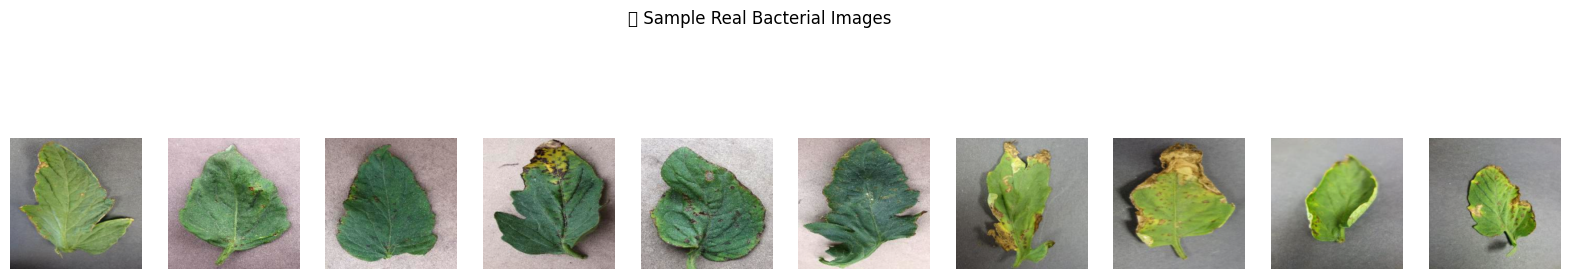

In [ ]:
# STEP 4: Show Sample Images
def show_images(images, title="", n=10):
    if len(images) == 0:
        print("⚠️ No images to display.")
        return
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(images))):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

real_images = [dataset[i] for i in range(min(10, len(dataset)))]
show_images(real_images, "✅ Sample Real Bacterial Images")


In [ ]:
# STEP 5: Diffusion Model Setup
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

model = UNet2DModel(
    sample_size=224,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    attention_head_dim=8
).to(device)

model.enable_xformers_memory_efficient_attention()

noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule="linear")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-6)


In [ ]:
# STEP 6: Training Loop
from tqdm.auto import tqdm

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)
num_epochs = 10
losses = []
accumulation_steps = 4

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        batch = batch.to(device)

        with torch.cuda.amp.autocast():
            noise = torch.randn_like(batch)
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.shape[0],)).long().to(device)
            noisy_images = noise_scheduler.add_noise(batch, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise) / accumulation_steps

        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            torch.cuda.empty_cache()

        epoch_loss += loss.item() * accumulation_steps

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} - Loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 1 - Loss: 0.2031


Epoch 2/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 2 - Loss: 0.2090


Epoch 3/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 3 - Loss: 0.4401


Epoch 4/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 4 - Loss: 0.4940


Epoch 5/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 5 - Loss: 0.3726


Epoch 6/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 6 - Loss: 0.2671


Epoch 7/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 7 - Loss: 0.2432


Epoch 8/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 8 - Loss: 0.2550


Epoch 9/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 9 - Loss: 0.2461


Epoch 10/10:   0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/tmp/ipython-input-6-2554157113.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute

✅ Epoch 10 - Loss: 0.2461


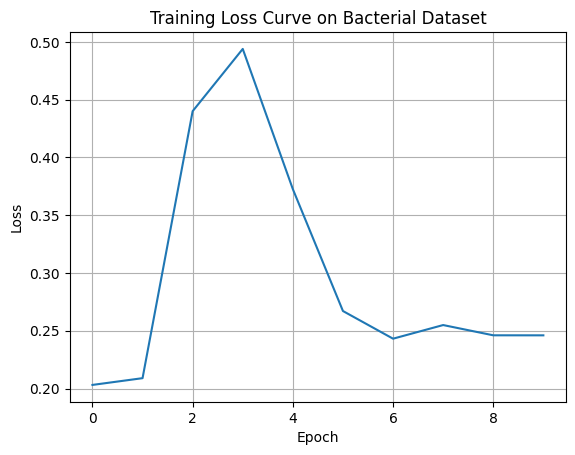

In [ ]:
# STEP 7: Plot Loss Curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve on Bacterial Dataset")
plt.grid(True)
plt.show()

In [ ]:
# STEP 8: Generate Synthetic Images
import gc
model.eval()
torch.cuda.empty_cache()
gc.collect()

pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler).to(device)

num_images = 50
gen_batch_size = 2
synthetic_images = []

print("🔄 Generating 50 synthetic bacterial images...")

for i in tqdm(range(0, num_images, gen_batch_size)):
    with torch.cuda.amp.autocast():
        images = pipeline(
            batch_size=gen_batch_size,
            num_inference_steps=500,
            generator=torch.manual_seed(42 + i),
            output_type="pil"
        ).images
    synthetic_images.extend(images)
    torch.cuda.empty_cache()

print(f"✅ Generated {len(synthetic_images)} synthetic bacterial images")

🔄 Generating 50 synthetic bacterial images...


  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-8-2223796325.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

✅ Generated 50 synthetic bacterial images


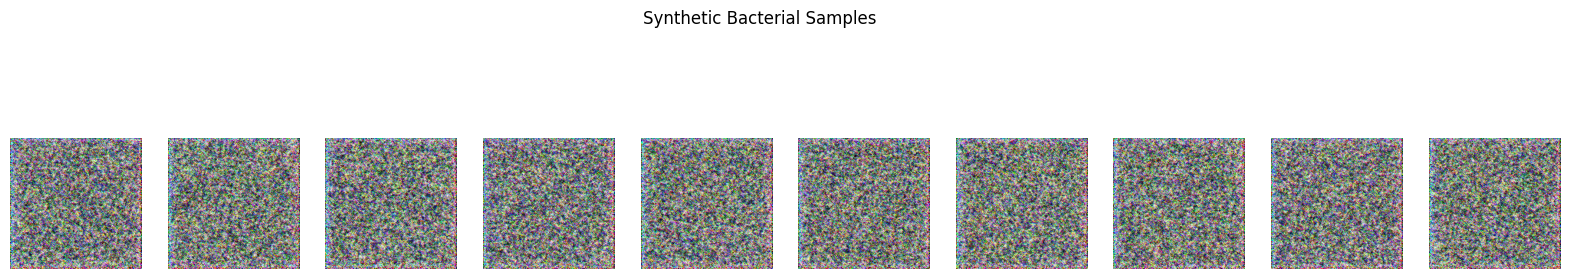

✅ All synthetic bacterial images saved in 'SyntheticBacterial' folder.


In [ ]:
# STEP 9: Show & Save Synthetic Images
def show_synthetic(images, title="Synthetic Bacterial Samples"):
    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    for i, img in enumerate(images[:10]):
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_synthetic(synthetic_images)

os.makedirs("SyntheticBacterial", exist_ok=True)
for i, img in enumerate(synthetic_images):
    img.save(f"SyntheticBacterial/synthetic_bacterial_{i:03d}.jpg")

print("✅ All synthetic bacterial images saved in 'SyntheticBacterial' folder.")